In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


## 数据准备

In [2]:
# !wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

In [3]:
# https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
#文件已经下载好了
with open("./shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print("length", len(text))
print(text[0:100])

length 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


### 构造字典

In [4]:
# 1. generate vocab
# 2. build mapping char->id
# 3. data -> id_data  把数据都转为id
# 4. a b c d [EOS] -> [BOS] b c d  预测下一个字符生成的模型，也就是输入是a，输出就是b

#去重，留下独立字符，并排序（排序是为了好看）
vocab = sorted(set(text))
print(len(vocab))
print(vocab)

65
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
for idx,char in enumerate(['h','o','w']):
    print(idx,char)

0 h
1 o
2 w


In [6]:
#每个字符都编好号，enumerate对每一个位置编号，生成的是列表中是元组，下面字典生成式
char2idx = {char:idx for idx, char in enumerate(vocab)}
print(char2idx)

{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}


In [7]:
# 把vocab从列表变为ndarray
idx2char = np.array(vocab)
print(idx2char)

['\n' ' ' '!' '$' '&' "'" ',' '-' '.' '3' ':' ';' '?' 'A' 'B' 'C' 'D' 'E'
 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W'
 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [8]:
#把字符都转换为id
text_as_int = np.array([char2idx[c] for c in text])
print(text_as_int.shape)
print(len(text_as_int))
print(text_as_int[0:10])
print(text[0:10])

(1115394,)
1115394
[18 47 56 57 58  1 15 47 58 47]
First Citi


In [9]:
1115394//101

11043

### 把莎士比亚文集分成一个一个的样本

In [10]:
from torch.utils.data import Dataset, DataLoader

class CharDataset(Dataset):
    #text_as_int是字符的id列表，seq_length是每个样本的长度
    def __init__(self, text_as_int, seq_length):
        self.sub_len = seq_length + 1 #一个样本的长度
        self.text_as_int = text_as_int
        self.num_seq = len(text_as_int) // self.sub_len #样本的个数
        
    def __getitem__(self, index):#index是样本的索引，返回的是一个样本，比如第一个，就是0-100的字符,总计101个字符
        return self.text_as_int[index * self.sub_len: (index + 1) * self.sub_len]
    
    def __len__(self): #返回样本的个数
        return self.num_seq

#batch是一个列表，列表中的每一个元素是一个样本，有101个字符，前100个是输入，后100个是输出
def collat_fct(batch):
    src_list = [] #输入
    trg_list = [] #输出
    for part in batch:
        src_list.append(part[:-1]) #输入
        trg_list.append(part[1:]) #输出
        
    src_list = np.array(src_list) #把列表转换为ndarray
    trg_list = np.array(trg_list) #把列表转换为ndarray
    return torch.Tensor(src_list).to(dtype=torch.int64), torch.Tensor(trg_list).to(dtype=torch.int64) #返回的是一个元组，元组中的每一个元素是一个torch.Tensor
        
#每个样本的长度是101，也就是100个字符+1个结束符
train_ds = CharDataset(text_as_int, 100)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collat_fct)

In [11]:
for datas, labels in train_dl:
    print(datas.shape)
    print(labels.shape)
    break

torch.Size([64, 100])
torch.Size([64, 100])


## 定义模型

In [12]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super(CharRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        #batch_first=True,输入的数据格式是(batch_size, seq_len, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden=None):
        x = self.embedding(x) #(batch_size, seq_len) -> (batch_size, seq_len, embedding_dim) (64, 100, 256)
        #这里和02的差异是没有只拿最后一个输出，而是把所有的输出都拿出来了
        #(batch_size, seq_len, embedding_dim)->(batch_size, seq_len, hidden_dim)(64, 100, 1024)
        output, hidden = self.rnn(x, hidden)
        x = self.fc(output) #[bs, seq_len, hidden_dim]--->[bs, seq_len, vocab_size] (64, 100,65)
        return x, hidden #x的shape是(batch_size, seq_len, vocab_size)
    
    
vocab_size = len(vocab)

print("{:=^80}".format(" 一层单向 RNN "))       
for key, value in CharRNN(vocab_size).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

=================================== 一层单向 RNN ===================================
            embedding.weight            paramerters num: 16640
            rnn.weight_ih_l0            paramerters num: 262144
            rnn.weight_hh_l0            paramerters num: 1048576
             rnn.bias_ih_l0             paramerters num: 1024
             rnn.bias_hh_l0             paramerters num: 1024
               fc.weight                paramerters num: 66560
                fc.bias                 paramerters num: 65


In [13]:
print(65*256)
print(256*1024)
print(1024*1024)
1024*65

16640
262144
1048576


66560

In [14]:
sample_inputs = torch.randint(0, vocab_size, (3, 100))
print(sample_inputs.shape)
model = CharRNN(vocab_size)
output=model(sample_inputs)
output[0].shape

torch.Size([3, 100])


torch.Size([3, 100, 65])

In [15]:
output[0].reshape(-1, vocab_size).shape

torch.Size([300, 65])

In [16]:

1024*65

66560

## 训练

In [17]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [18]:
# 训练
def training(
    model, 
    train_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    save_ckpt_callback=None,
    stateful=False      # 想用stateful，batch里的数据就必须连续，不能打乱
    ):
    record_dict = {
        "train": [],
    }
    
    global_step = 0
    model.train()
    hidden = None
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算,如果数据集打乱了，stateful=False，hidden就要清空
                # 如果数据集没有打乱，stateful=True，hidden就不需要清空
                logits, hidden = model(datas, hidden=hidden if stateful else None)
                # 计算损失,交叉熵损失第一个参数要是二阶张量，第二个参数要是一阶张量，所以要reshape
                loss = loss_fct(logits.reshape(-1, vocab_size), labels.reshape(-1))
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
 
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })
   
                # 保存模型权重 save model checkpoint
                if save_ckpt_callback is not None:
                    save_ckpt_callback(global_step, model.state_dict(), metric=-loss)
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 100

model = CharRNN(vocab_size=vocab_size)

# 1. 定义损失函数 采用交叉熵损失 
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/text_generation", save_step=1000, save_best_only=True)


model = model.to(device)


In [19]:
record = training(
    model,
    train_dl,
    epoch,
    loss_fct,
    optimizer,
    save_ckpt_callback=save_ckpt_callback,
    )

100%|██████████| 17300/17300 [03:14<00:00, 88.74it/s, epoch=99]


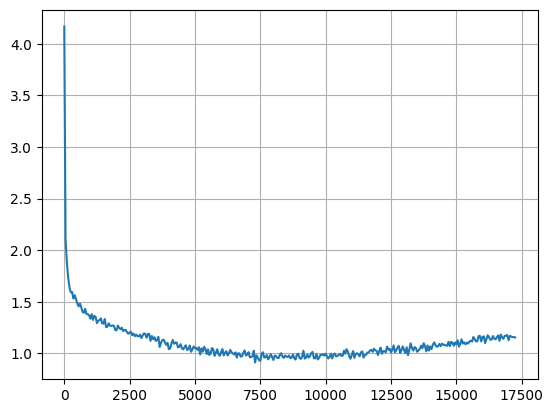

In [20]:
plt.plot([i["step"] for i in record["train"][::50]], [i["loss"] for i in record["train"][::50]], label="train")
plt.grid()
plt.show()

## 推理

In [21]:
#下面的例子是为了说明temperature
my_tensor = torch.tensor([0.4,0.6]) #这里是logits

probs1 = F.softmax(my_tensor, dim=-1)
print(probs1)

tensor([0.4502, 0.5498])


In [22]:
my_tensor = torch.tensor([0.2,0.3])  #现在 temperature是2

probs1 = F.softmax(my_tensor, dim=-1)
print(probs1)

tensor([0.4750, 0.5250])


In [23]:
import torch

# 创建一个概率分布，表示每个类别被选中的概率
# 这里我们有一个简单的四个类别的概率分布
prob_dist = torch.tensor([0.1, 0.45, 0.35, 0.1])

# 使用 multinomial 进行抽样
# num_samples 表示要抽取的样本数量
num_samples = 5

# 抽取样本，随机抽样，概率越高，抽到的概率就越高
samples = torch.multinomial(prob_dist, 1, replacement=True)

print("概率分布:", prob_dist)
print("抽取的样本索引:", samples)

# 显示每个样本对应的概率
print("每个样本对应的概率:", prob_dist[samples])

概率分布: tensor([0.1000, 0.4500, 0.3500, 0.1000])
抽取的样本索引: tensor([2])
每个样本对应的概率: tensor([0.3500])


In [24]:
def generate_text(model, start_string, max_len=1000, temperature=1.0, stream=True):
    # 将起始字符串转换为模型输入
    # char2idx 是一个字典，将字符映射为索引
    # torch.Tensor 将字符索引列表转换为张量，并调整数据类型和设备
    # reshape(1, -1) 将输入形状调整为 [batch_size=1, seq_length]
    input_eval = torch.Tensor([char2idx[char] for char in start_string]).to(dtype=torch.int64, device=device).reshape(1, -1)
    
    hidden = None  # 初始化隐藏状态
    text_generated = []  # 用于保存生成的文本
    model.eval()  # 将模型设置为评估模式
    pbar = tqdm(range(max_len))  # 进度条，控制生成文本的长度
    print(start_string, end="")  # 打印起始字符串

    # no_grad 是一个上下文管理器，用于指定在其中的代码块中不需要计算梯度
    # 在这个区域内，不会记录梯度信息，用于在生成文本时不影响模型权重
    with torch.no_grad():
        for i in pbar:  # 控制进度条
            # 模型前向传播，获取输出 logits 和隐藏状态 hidden
            logits, hidden = model(input_eval, hidden=hidden)
            
            # 温度采样
            # 取最后一个时间步的输出 logits，并除以温度值
            # 温度值越高，生成的文本越随机；温度值越低，生成的文本越保守
            logits = logits[0, -1, :] / temperature
            
            # 使用 softmax 将 logits 转换为概率分布
            probs = F.softmax(logits, dim=-1)
            
            # 从概率分布中采样一个字符索引
            idx = torch.multinomial(probs, 1).item()
            
            # 将采样得到的字符索引转换为模型输入
            input_eval = torch.Tensor([idx]).to(dtype=torch.int64, device=device).reshape(1, -1)
            
            # 将生成的字符索引保存到列表中
            text_generated.append(idx)
            
            # 如果 stream 为 True，则实时打印生成的字符
            if stream:
                print(idx2char[idx], end="", flush=True)
    
    # 将生成的字符索引列表转换为字符串并返回
    return "".join([idx2char[i] for i in text_generated])

In [25]:
# 加载模型检查点
model.load_state_dict(torch.load("checkpoints/text_generation/best.ckpt", map_location="cpu"))

# 设置起始字符串
start_string = "All: "

# 生成文本
res = generate_text(model, start_string, max_len=1000, temperature=0.5, stream=True)

/tmp/ipykernel_460/835159976.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/text_generation/best.ckpt", map_location="cpu"

All: I

  0%|          | 1/1000 [00:00<04:01,  4.13it/s]

 cannot now a strange report of any of your sorrow's eye,


  6%|▌         | 59/1000 [00:00<00:04, 217.68it/s]

And be it forth to come of this.

Clown:
Alack, the vile the common of 

 13%|█▎        | 130/1000 [00:00<00:02, 387.59it/s]

the sea-should success shall put
He that runs for his propert to repen

 20%|██        | 200/1000 [00:00<00:01, 490.57it/s]

t;
Go, crave I need of men,
Should wish me not with me; let him not confederatio

 28%|██▊       | 280/1000 [00:00<00:01, 587.89it/s]

n of my company.

KING RICHARD III:
Why, she, my lord?

KING RICHARD II

 35%|███▌      | 351/1000 [00:00<00:01, 623.56it/s]

:
What says he?

Nurse:
What is the frowns of his majesty
With all my house

 43%|████▎     | 426/1000 [00:00<00:00, 662.40it/s]

 to assurance of his love
Than thou must be here.

Second Citizen:
And if thou wee

 51%|█████     | 508/1000 [00:00<00:00, 708.07it/s]

p'st off the heart,
Or else it will not be long.
The gods be seen.

First S

 58%|█████▊    | 583/1000 [00:01<00:00, 720.05it/s]

enator:
How canst not say you hear.

CLARENCE:
And therefore has he dispat

 66%|██████▌   | 657/1000 [00:01<00:00, 707.89it/s]

ch of him,
And leave you thus I told you stay.

EDWARD:
Now the report it

 73%|███████▎  | 730/1000 [00:01<00:00, 705.32it/s]

. My dear king,
For fearing you would seem still will not be proud to ha

 80%|████████  | 802/1000 [00:01<00:00, 697.24it/s]

ve a stubborn and fortune enough not what the heart of heaven,
To choose but t

 88%|████████▊ | 880/1000 [00:01<00:00, 718.97it/s]

hat the foolish women, and leave me so much some prick'd in a house of Lancast

 96%|█████████▌| 958/1000 [00:01<00:00, 735.35it/s]

er.

PROSPERO:
Thou hast lost too late!

M

100%|██████████| 1000/1000 [00:01<00:00, 617.04it/s]


In [26]:
print(res)

I cannot now a strange report of any of your sorrow's eye,
And be it forth to come of this.

Clown:
Alack, the vile the common of the sea-should success shall put
He that runs for his propert to repent;
Go, crave I need of men,
Should wish me not with me; let him not confederation of my company.

KING RICHARD III:
Why, she, my lord?

KING RICHARD II:
What says he?

Nurse:
What is the frowns of his majesty
With all my house to assurance of his love
Than thou must be here.

Second Citizen:
And if thou weep'st off the heart,
Or else it will not be long.
The gods be seen.

First Senator:
How canst not say you hear.

CLARENCE:
And therefore has he dispatch of him,
And leave you thus I told you stay.

EDWARD:
Now the report it. My dear king,
For fearing you would seem still will not be proud to have a stubborn and fortune enough not what the heart of heaven,
To choose but that the foolish women, and leave me so much some prick'd in a house of Lancaster.

PROSPERO:
Thou hast lost too late!

M